In [1]:
import os
import multiprocessing
multiprocessing.cpu_count()

16

In [2]:
import mxnet as mx
import gluonnlp as nlp
from mxnet.contrib import amp

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sacremoses
import time
from tqdm.notebook import tqdm
import io
from importlib import reload

# Local Libraries
import nmt
import dataprocessor
import utils
import nmt.transformer_hparams
import transformer_model

# Hyperparameters for Dataloaders and Training
hparams = nmt.transformer_hparams

# Seeds for reproducibility
np.random.seed(100)
random.seed(100)
mx.random.seed(100)

## Dataset Import

In [3]:
# WMT2016 Dataset
src_lang, tgt_lang = "en", "de"

wmt2016_train_data = nlp.data.WMT2016BPE(
    'train',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_val_data = nlp.data.WMT2016BPE(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_test_data = nlp.data.WMT2016BPE(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

# Text sentences for evaluation
wmt2016_val_text = nlp.data.WMT2016(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_test_text = nlp.data.WMT2016(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

src_max_len, tgt_max_len = 50, 50

In [4]:
# Train data test
# train_length = 100000
train_length = 3000
wmt2016_train_data._data[0] = wmt2016_train_data._data[0][:train_length]
wmt2016_train_data._data[1] = wmt2016_train_data._data[1][:train_length]
wmt2016_train_data._length = train_length

# Split Val / Test sets
# val_length = 1500
# test_length = len(wmt2016_test_text) - val_length
val_length = 300
test_length = 300
test_length = 1500

wmt2016_val_data._data[0] = wmt2016_val_data._data[0][:val_length]
wmt2016_val_data._data[1] = wmt2016_val_data._data[1][:val_length]
wmt2016_val_data._length = val_length

wmt2016_val_text._data[0] = wmt2016_val_text._data[0][:val_length]
wmt2016_val_text._data[1] = wmt2016_val_text._data[1][:val_length]
wmt2016_val_text._length = val_length

wmt2016_test_data._data[0] = wmt2016_test_data._data[0][-test_length:]
wmt2016_test_data._data[1] = wmt2016_test_data._data[1][-test_length:]
wmt2016_test_data._length = test_length

wmt2016_test_text._data[0] = wmt2016_test_text._data[0][-test_length:]
wmt2016_test_text._data[1] = wmt2016_test_text._data[1][-test_length:]
wmt2016_test_text._length = test_length

In [5]:
print("Length of train set:", len(wmt2016_train_data))
print("Length of val set  :", len(wmt2016_val_data))
print("Length of test set :", len(wmt2016_test_data))

Length of train set: 3000
Length of val set  : 300
Length of test set : 1500


In [6]:
wmt2016_val_tgt_sentences = wmt2016_val_text.transform(lambda src, tgt: tgt, lazy=False)
wmt2016_test_tgt_sentences = wmt2016_test_text.transform(lambda src, tgt: tgt, lazy=False)

In [7]:
reload(transformer_model)

# For vocab
wmt_model_name = "transformer_en_de_512"
_, wmt_src_vocab, wmt_tgt_vocab = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=mx.cpu())

# Pre-processing WMT2016
wmt_transform_fn = dataprocessor.TrainValDataTransform(
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    src_max_len,
    tgt_max_len)

wmt2016_train_data_processed = wmt2016_train_data.transform(
    wmt_transform_fn)

wmt2016_val_data_processed = wmt2016_val_data.transform(
    wmt_transform_fn)

wmt2016_test_data_processed = wmt2016_test_data.transform(
    wmt_transform_fn)

wmt2016_train_data_lengths = transformer_model.get_data_lengths(wmt2016_train_data_processed)
wmt2016_val_data_lengths = transformer_model.get_data_lengths(wmt2016_val_data_processed)
wmt2016_test_data_lengths = transformer_model.get_data_lengths(wmt2016_test_data_processed)

/home/ext_andres_pereztorres_oxbotica_/.local/lib/python3.9/site-packages/gluonnlp/vocab/vocab.py:590: UserWarning: Detected a corrupted index in the deserialize vocabulary. For versions before GluonNLP v0.7 the index is corrupted by specifying the same token for different special purposes, for example eos_token == padding_token. Deserializing the vocabulary nevertheless.
  warnings.warn(


In [8]:
# Add Lengths to the datasets and indexes for validation and test
wmt2016_train_data_len_processed = wmt2016_train_data_processed.transform(lambda src, tgt: (src, tgt, len(src), len(tgt)), lazy=False)
wmt2016_val_data_len_processed = wmt2016_val_data_processed.transform(transformer_model.get_length_index_fn(), lazy=False)
wmt2016_test_data_len_processed = wmt2016_test_data_processed.transform(transformer_model.get_length_index_fn(), lazy=False)

In [9]:
train_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'))

val_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack())

In [18]:
reload(transformer_model)

bucket_scheme = nlp.data.ExpWidthBucket(bucket_len_step=1.2)

wmt2016_train_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_train_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size,
    shuffle=True)

wmt2016_val_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_val_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.test_batch_size,
    shuffle=False)

wmt2016_test_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_test_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size,
    shuffle=False)

In [19]:
num_workers = 0

wmt2016_train_data_loader = nlp.data.ShardedDataLoader(
    wmt2016_train_data_len_processed,
    batch_sampler=wmt2016_train_batch_sampler,
    batchify_fn=train_batchify_fn,
    num_workers=num_workers)

wmt2016_val_data_loader = nlp.data.ShardedDataLoader(
    wmt2016_val_data_len_processed,
    batch_sampler=wmt2016_val_batch_sampler,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

wmt2016_test_data_loader = nlp.data.ShardedDataLoader(
    wmt2016_test_data_len_processed,
    batch_sampler=wmt2016_test_batch_sampler,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

## Naive Training

In [21]:
# Single GPU training
ctx_list = [mx.gpu(0)]

In [22]:
# Build on top of Pre-Trained model
wmt_model_name = 'transformer_en_de_512'
wmt_transformer_model_ft_direct, _, _ = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx_list)

print('Source Vocab:', len(wmt_src_vocab), ', Target Vocab:', len(wmt_tgt_vocab))

# No need to re-configure last layer, just re-initialize
# wmt_transformer_model_ft_direct.tgt_proj.initialize(ctx=ctx, force_reinit=True)

model_filename_ft_direct = "transformer_en_de_512_ft_direct.params"

wmt_translator_ft_direct = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_model_ft_direct,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

# hparams.epochs = 10
hparams.epochs = 2
hparams.lr = 0.00003
hparams.log_interval = 100

loss_function = nlp.loss.MaskedSoftmaxCELoss()

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

Source Vocab: 36794 , Target Vocab: 36794


In [23]:
reload(transformer_model)

# Let's train
trainer = mx.gluon.Trainer(wmt_transformer_model_ft_direct.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

best_valid_bleu = 0.0

wmt2016_train_losses = []
wmt2016_valid_losses = []
wmt2016_valid_bleus  = []
wmt2016_valid_perplexities = []

start_time = time.time()

for epoch_id in tqdm(range(hparams.epochs)):

    acc_train_loss_batch = 0
    log_loss = 0
    log_denom = 0
    log_wc = 0
    log_start_time = time.time()

    # Iterate through each batch
    # for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(wmt2016_train_data_loader)):
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length, _) in enumerate(tqdm(wmt2016_test_data_loader)):

        src_seq = src_seq.as_in_context(ctx_list[0])
        tgt_seq = tgt_seq.as_in_context(ctx_list[0])
        src_valid_length = src_valid_length.as_in_context(ctx_list[0])
        tgt_valid_length = tgt_valid_length.as_in_context(ctx_list[0])
        
        with mx.autograd.record():
            out, _ = wmt_transformer_model_ft_direct(
                src_seq,
                tgt_seq[:, :-1],
                src_valid_length,
                tgt_valid_length - 1)

            loss = loss_function(out, tgt_seq[:, 1:], tgt_valid_length - 1).mean()
            
            loss.backward()
            loss = loss * (tgt_seq.shape[1] - 1)
            log_loss += loss * tgt_seq.shape[0]
            log_denom += (tgt_valid_length - 1).sum()
            loss = loss / (tgt_valid_length - 1).mean()

        trainer.step(1)
        
        src_wc = src_valid_length.sum().asscalar()
        tgt_wc = (tgt_valid_length - 1).sum().asscalar()
        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_wc += src_wc + tgt_wc
        
        train_loss = log_loss / log_denom
        acc_train_loss_batch += train_loss
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(wmt2016_train_data_loader),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 wps / 1000, log_wc / 1000))
            
            log_start_time = time.time()
            log_loss = 0
            log_denom = 0
            log_avg_gnorm = 0
            log_wc = 0

    wmt2016_train_loss = acc_train_loss_batch / len(wmt2016_train_data_loader)
    wmt2016_train_losses.append(wmt2016_train_loss)
    
    # Validation step
    wmt2016_valid_loss, wmt2016_valid_translation_out = transformer_model.evaluate(
        wmt_transformer_model_ft_direct,
        wmt2016_val_data_loader,
        loss_function,
        wmt_translator_ft_direct,
        # wmt2016_train_data.tgt_vocab,
        wmt_tgt_vocab,
        wmt_detokenizer,
        ctx_list[0])

    wmt2016_valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
        [wmt2016_val_tgt_sentences],
        wmt2016_valid_translation_out,
        tokenized=False,
        tokenizer="13a",
        split_compound_word=False,
        bpe=False)
    
    wmt2016_valid_perplexity = np.exp(wmt2016_valid_loss)
    wmt2016_valid_perplexities.append(wmt2016_valid_perplexity)
    wmt2016_valid_losses.append(wmt2016_valid_loss)
    wmt2016_valid_bleus.append(wmt2016_valid_bleu_score * 100)
    
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, wmt2016_valid_loss, wmt2016_valid_perplexity, wmt2016_valid_bleu_score * 100))
    
    if wmt2016_valid_bleu_score > best_valid_bleu:
        best_valid_bleu = wmt2016_valid_bleu_score
        print("Save best parameters to {}".format(model_filename_ft_direct))
        wmt_transformer_model_ft_direct.save_parameters(model_filename_ft_direct)
    
print("Training time for 10 epochs:", time.time() - start_time, "/ Best validation loss:", min(wmt2016_valid_losses))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

[Epoch 0 Batch 100/445] loss=1.6997, ppl=5.4721, throughput=4.23K wps, wc=43.96K


  0%|          | 0/192 [00:00<?, ?it/s]

[Epoch 0] valid Loss=1.4483, valid ppl=4.2557, valid bleu=31.72
Save best parameters to transformer_en_de_512_ft_direct.params


  0%|          | 0/184 [00:00<?, ?it/s]

[Epoch 1 Batch 100/445] loss=1.4333, ppl=4.1925, throughput=4.75K wps, wc=43.96K


  0%|          | 0/192 [00:00<?, ?it/s]

[Epoch 1] valid Loss=1.4232, valid ppl=4.1503, valid bleu=29.27
Training time for 10 epochs: 422.52239179611206 / Best validation loss: 1.423180778719894


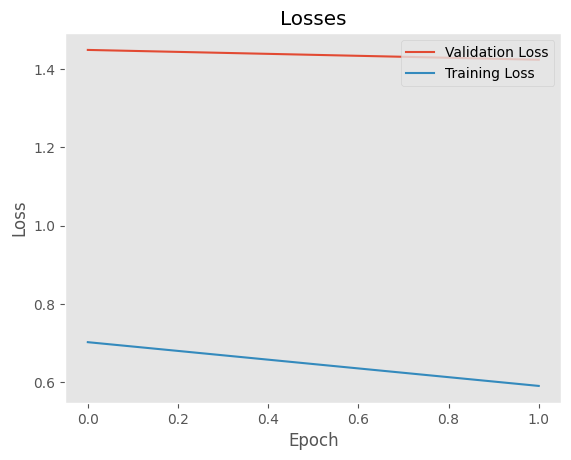

In [24]:
# plot the losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, hparams.epochs), wmt2016_valid_losses, label="Validation Loss")
plt.plot(np.arange(0, hparams.epochs), wmt2016_train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

### Evaluation

#### Quantitative Evaluation: Test Loss and BLEU score

In [25]:
# Quantitative Evaluation
# Load best model
wmt_transformer_model_ft_direct.load_parameters(model_filename_ft_direct)

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate(
    wmt_transformer_model_ft_direct,
    wmt2016_test_data_loader,
    loss_function,
    wmt_translator_ft_direct,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx_list[0])

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/184 [00:00<?, ?it/s]

WMT16 test loss: 1.18; test bleu score: 34.71


#### Qualitative Evaluation: Translation from English to German Example

In [26]:
# Qualitative Evaluation
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne neue Dinge jeden Tag."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# translation_out = nmt.utils.translate_with_unk(
# translation_out = nmt.utils.translate(
translation_out = transformer_model.translate(
    wmt_translator_ft_direct,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx_list[0])

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne jeden Tag neue Dinge.
In English:
I learn new things every day.
The German translation is:
Ich lerne immer wieder Neues


## Optimal Data Loading: CPU/GPU Optimization

In [27]:
# Context variable is now a list,
# with each element corresponding to a GPU device
ctx_list = [mx.gpu(0), mx.gpu(1), mx.gpu(2), mx.gpu(3)]
num_gpus = len(ctx_list)

In [28]:
# From strings converted to ND arrays,
# we can continue processing in GPU
wmt2016_train_data_processed_gpu = mx.gluon.data.SimpleDataset(
    [(mx.nd.array(data).as_in_context(ctx_list[idx % num_gpus]), mx.nd.array(label).as_in_context(ctx_list[idx % num_gpus])) 
     for idx, (data, label) in enumerate(wmt2016_train_data_processed)])

wmt2016_val_data_processed_gpu = mx.gluon.data.SimpleDataset(
    [(mx.nd.array(data).as_in_context(ctx_list[idx % num_gpus]), mx.nd.array(label).as_in_context(ctx_list[idx % num_gpus])) 
     for idx, (data, label) in enumerate(wmt2016_val_data_processed)])

wmt2016_test_data_processed_gpu = mx.gluon.data.SimpleDataset(
    [(mx.nd.array(data).as_in_context(ctx_list[idx % num_gpus]), mx.nd.array(label).as_in_context(ctx_list[idx % num_gpus])) 
     for idx, (data, label) in enumerate(wmt2016_test_data_processed)])

In [29]:
wmt2016_train_data_len_processed_gpu = wmt2016_train_data_processed_gpu.transform(lambda src, tgt: (src, tgt, len(src), len(tgt)), lazy=False)
wmt2016_val_data_len_processed_gpu = wmt2016_val_data_processed_gpu.transform(transformer_model.get_length_index_fn(), lazy=False)
wmt2016_test_data_len_processed_gpu = wmt2016_test_data_processed_gpu.transform(transformer_model.get_length_index_fn(), lazy=False)

In [30]:
reload(transformer_model)

bucket_scheme = nlp.data.ExpWidthBucket(bucket_len_step=1.2)

wmt2016_train_batch_sampler_gpu = nlp.data.FixedBucketSampler(
    lengths=wmt2016_train_data_lengths,
    # use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    use_average_length=False,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size * 4,
    shuffle=True)

wmt2016_val_batch_sampler_gpu = nlp.data.FixedBucketSampler(
    lengths=wmt2016_val_data_lengths,
    # use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    use_average_length=False,
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size * 4,
    shuffle=False)

wmt2016_test_batch_sampler_gpu = nlp.data.FixedBucketSampler(
    lengths=wmt2016_test_data_lengths,
    # use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    use_average_length=False,
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size * 4,
    shuffle=False)

In [31]:
num_workers = 0

wmt2016_train_data_loader_gpu = mx.gluon.data.DataLoader(
    wmt2016_train_data_len_processed_gpu,
    batch_sampler=wmt2016_train_batch_sampler_gpu,
    batchify_fn=train_batchify_fn,
    num_workers=num_workers)

wmt2016_val_data_loader_gpu = mx.gluon.data.DataLoader(
    wmt2016_val_data_len_processed_gpu,
    batch_sampler=wmt2016_val_batch_sampler_gpu,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

wmt2016_test_data_loader_gpu = mx.gluon.data.DataLoader(
    wmt2016_test_data_len_processed_gpu,
    batch_sampler=wmt2016_test_batch_sampler_gpu,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

## Optimal Training: Automatic Mixed Precision (AMP) + Multi-GPU

In [32]:
ctx_list = [mx.gpu(0), mx.gpu(1), mx.gpu(2), mx.gpu(3)]

In [33]:
# AMP
amp.init()

# Build on top of Pre-Trained model
wmt_model_name = 'transformer_en_de_512'
wmt_transformer_model_ft_direct_opt, _, _ = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx_list)

print('Source Vocab:', len(wmt_src_vocab), ', Target Vocab:', len(wmt_tgt_vocab))

# No need to re-configure last layer, just re-initialize
# wmt_transformer_model_ft_direct.tgt_proj.initialize(ctx=ctx_list, force_reinit=True)

wmt_transformer_model_ft_direct_opt.hybridize(static_alloc=True, static_shape=True)

model_filename_ft_direct_opt = "transformer_en_de_512_ft_direct_opt.params"


wmt_translator_ft_direct_opt = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_model_ft_direct_opt,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

# hparams.epochs = 10
hparams.epochs = 2
# hparams.lr = 0.00003
hparams.lr = 0.0001
hparams.log_interval = 1

loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

/home/ext_andres_pereztorres_oxbotica_/.local/lib/python3.9/site-packages/gluonnlp/vocab/vocab.py:590: UserWarning: Detected a corrupted index in the deserialize vocabulary. For versions before GluonNLP v0.7 the index is corrupted by specifying the same token for different special purposes, for example eos_token == padding_token. Deserializing the vocabulary nevertheless.
  warnings.warn(


Source Vocab: 36794 , Target Vocab: 36794


In [34]:
wmt2016_train_data_loader_gpu = wmt2016_test_data_loader_gpu

In [35]:
reload(transformer_model)

# Let's train
trainer = mx.gluon.Trainer(wmt_transformer_model_ft_direct_opt.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

best_valid_bleu = 0.0

wmt2016_train_losses = []
wmt2016_valid_losses = []
wmt2016_valid_bleus  = []
wmt2016_valid_perplexities = []

amp.init_trainer(trainer)

start_time = time.time()

for epoch_id in tqdm(range(hparams.epochs)):

    acc_train_loss_batch = 0
    log_loss = 0
    log_denom = 0
    log_wc = 0
    log_start_time = time.time()

    # Iterate through each batch
    # for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(wmt2016_train_data_loader_gpu)):
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length, _) in enumerate(tqdm(wmt2016_train_data_loader_gpu)):
               
        src_seq_list = mx.gluon.utils.split_and_load(src_seq, ctx_list=ctx_list, even_split=False)
        tgt_seq_list = mx.gluon.utils.split_and_load(tgt_seq, ctx_list=ctx_list, even_split=False)
        src_valid_length_list = mx.gluon.utils.split_and_load(src_valid_length, ctx_list=ctx_list, even_split=False)
        tgt_valid_length_list = mx.gluon.utils.split_and_load(tgt_valid_length, ctx_list=ctx_list, even_split=False)
        
        losses = []
        
        with mx.autograd.record():
            for src_seq_slice, tgt_seq_slice, src_valid_length_slice, tgt_valid_length_slice in zip(src_seq_list, tgt_seq_list, src_valid_length_list, tgt_valid_length_list):
                
                assert src_seq_slice.context == tgt_seq_slice.context == src_valid_length_slice.context == tgt_valid_length_slice.context                
                
                out_slice, _ = wmt_transformer_model_ft_direct_opt(
                    src_seq_slice,
                    tgt_seq_slice[:, :-1],
                    src_valid_length_slice,
                    tgt_valid_length_slice - 1)
                
                loss = loss_function(out_slice, tgt_seq_slice[:, 1:], tgt_valid_length_slice - 1)
                loss.backward()
                
#                 with amp.scale_loss(loss, trainer) as scaled_loss:
#                     scaled_loss.backward()
                    
                losses.append(loss)
        
        trainer.step(1)
        
        src_wc = 0
        tgt_wc = 0
        
        for loss, tgt_seq_slice, src_valid_length_slice, tgt_valid_length_slice in zip(losses, tgt_seq_list, src_valid_length_list, tgt_valid_length_list):
            
            assert loss.context == tgt_seq_slice.context == src_valid_length_slice.context == tgt_valid_length_slice.context
            
            src_valid_length_slice_cpu = src_valid_length_slice.as_in_context(mx.cpu())
            tgt_valid_length_slice_cpu = tgt_valid_length_slice.as_in_context(mx.cpu())
            
            loss = loss.mean().as_in_context(mx.cpu()) * (tgt_seq_slice.shape[1] - 1)
            log_loss += loss * tgt_seq_slice.shape[0]
            log_denom += (tgt_valid_length_slice_cpu - 1).sum()
            loss = loss / (tgt_valid_length_slice_cpu - 1).mean()
            
            src_wc += src_valid_length_slice_cpu.sum().asscalar()
            tgt_wc += (tgt_valid_length_slice_cpu - 1).sum().asscalar()
        

        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_wc += src_wc + tgt_wc
            
        train_loss = log_loss / log_denom
        acc_train_loss_batch += train_loss
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(wmt2016_train_data_loader_gpu),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 wps / 1000, log_wc / 1000))
            
            log_loss = 0
            log_denom = 0
            log_wc = 0

    wmt2016_train_loss = acc_train_loss_batch / len(wmt2016_train_data_loader_gpu)
    wmt2016_train_losses.append(wmt2016_train_loss)
    
    # Validation step
    wmt2016_valid_loss, wmt2016_valid_translation_out = transformer_model.evaluate_multi(
        wmt_transformer_model_ft_direct_opt,
        wmt2016_val_data_loader_gpu,
        loss_function,
        wmt_translator_ft_direct_opt,
        wmt_tgt_vocab,
        wmt_detokenizer,
        ctx_list=ctx_list)

    wmt2016_valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
        [wmt2016_val_tgt_sentences],
        wmt2016_valid_translation_out,
        tokenized=False,
        tokenizer="13a",
        split_compound_word=False,
        bpe=False)

    wmt2016_valid_perplexity = np.exp(wmt2016_valid_loss)
    wmt2016_valid_perplexities.append(wmt2016_valid_perplexity)
    wmt2016_valid_losses.append(wmt2016_valid_loss)
    wmt2016_valid_bleus.append(wmt2016_valid_bleu_score * 100)
    
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, wmt2016_valid_loss, wmt2016_valid_perplexity, wmt2016_valid_bleu_score * 100))
    
    if wmt2016_valid_bleu_score > best_valid_bleu:
        best_valid_bleu = wmt2016_valid_bleu_score
        print("Save best parameters to {}".format(model_filename_ft_direct_opt))
        wmt_transformer_model_ft_direct_opt.save_parameters(model_filename_ft_direct_opt)

print("Training time for 10 epochs:", time.time() - start_time, "/ Best validation loss:", min(wmt2016_valid_losses))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/home/ext_andres_pereztorres_oxbotica_/.local/lib/python3.9/site-packages/gluonnlp/data/batchify/batchify.py:268: UserWarning: Using Pad with NDArrays is discouraged for speed reasons. Instead you should pad your data while it is still a list and before converting to an NDArray. Alternatively you can consider inputting a numpy.ndarray.
  warnings.warn(
[20:27:05] /work/mxnet/src/kvstore/././comm.h:741: only 4 out of 12 GPU pairs are enabled direct access. It may affect the performance. You can set MXNET_ENABLE_GPU_P2P=0 to turn it off
[20:27:05] /work/mxnet/src/kvstore/././comm.h:750: .v..
[20:27:05] /work/mxnet/src/kvstore/././comm.h:750: v...
[20:27:05] /work/mxnet/src/kvstore/././comm.h:750: ...v
[20:27:05] /work/mxnet/src/kvstore/././comm.h:750: ..v.


[Epoch 0 Batch 1/5] loss=1.8940, ppl=6.6460, throughput=4.30K wps, wc=27.86K
[Epoch 0 Batch 2/5] loss=1.6214, ppl=5.0600, throughput=2.69K wps, wc=18.67K
[Epoch 0 Batch 3/5] loss=1.6833, ppl=5.3833, throughput=2.45K wps, wc=17.91K
[Epoch 0 Batch 4/5] loss=1.7594, ppl=5.8087, throughput=1.45K wps, wc=11.32K
[Epoch 0 Batch 5/5] loss=1.5125, ppl=4.5382, throughput=0.24K wps, wc=1.95K


  0%|          | 0/5 [00:00<?, ?it/s]

[20:27:13] /work/mxnet/src/imperative/./cached_op.h:254: Disabling fusion due to altered topological order of inputs.
[20:27:20] /work/mxnet/src/imperative/./cached_op.h:254: Disabling fusion due to altered topological order of inputs.
[20:27:24] /work/mxnet/src/imperative/./cached_op.h:254: Disabling fusion due to altered topological order of inputs.
[20:27:28] /work/mxnet/src/imperative/./cached_op.h:254: Disabling fusion due to altered topological order of inputs.


[Epoch 0] valid Loss=1.2648, valid ppl=3.5423, valid bleu=32.11
Save best parameters to transformer_en_de_512_ft_direct_opt.params


  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 1 Batch 1/5] loss=1.6425, ppl=5.1679, throughput=49.74K wps, wc=27.86K
[Epoch 1 Batch 2/5] loss=1.4529, ppl=4.2754, throughput=19.04K wps, wc=18.67K
[Epoch 1 Batch 3/5] loss=1.5094, ppl=4.5240, throughput=13.14K wps, wc=17.91K
[Epoch 1 Batch 4/5] loss=1.5751, ppl=4.8313, throughput=6.59K wps, wc=11.32K
[Epoch 1 Batch 5/5] loss=1.3221, ppl=3.7512, throughput=0.91K wps, wc=1.95K


  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 1] valid Loss=1.2443, valid ppl=3.4706, valid bleu=32.19
Save best parameters to transformer_en_de_512_ft_direct_opt.params
Training time for 10 epochs: 91.03781414031982 / Best validation loss: 1.2443209995368594


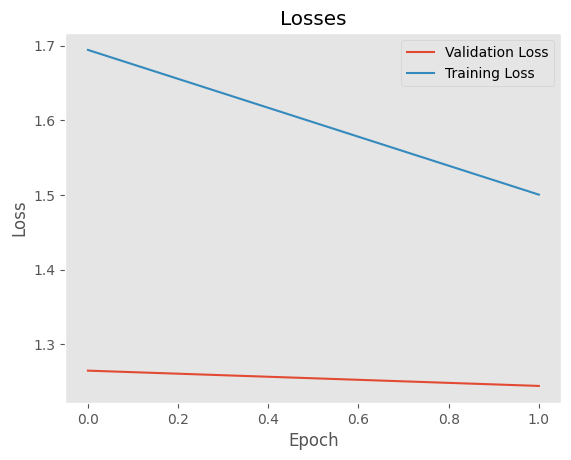

In [36]:
# plot the losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, hparams.epochs), wmt2016_valid_losses, label="Validation Loss")
plt.plot(np.arange(0, hparams.epochs), wmt2016_train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

### Evaluation

#### Quantitative Evaluation: Test Loss and BLEU score

In [39]:
# Quantitative Evaluation
# Load best model
wmt_transformer_model_ft_direct_opt.load_parameters(model_filename_ft_direct_opt)

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate_multi(
    wmt_transformer_model_ft_direct_opt,
    wmt2016_test_data_loader_gpu,
    loss_function,
    wmt_translator_ft_direct_opt,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx_list)

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/5 [00:00<?, ?it/s]

WMT16 test loss: 1.14; test bleu score: 34.90


#### Qualitative Evaluation: Translation from English to German Example

In [40]:
# Qualitative Evaluation
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne neue Dinge jeden Tag."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# translation_out = nmt.utils.translate_with_unk(
# translation_out = nmt.utils.translate(
translation_out = transformer_model.translate(
    wmt_translator_ft_direct_opt,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx_list[0])

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne jeden Tag neue Dinge.
In English:
I learn new things every day.
The German translation is:
Ich lerne Neues in jedem Fall
